In [1]:
%load_ext autoreload
%autoreload 2

# Deep Learning Project
## AlexNet Implementation

# Load Packages

In [2]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image

import torch


# Random Seed for Reproduction

In [3]:
from torch import manual_seed as torch_manual_seed
import random
import numpy as np

from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 42
setup_seed(SEED)

# Import Dataset

In [4]:
# Extract contenty
!unzip -q "CIFAR.zip"

replace test/FAKE/0 (10).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [5]:
from sklearn.datasets import load_files

data_dir_train = "train/"
data_dir_test = "test/"
batch_size = 32;


In [6]:
from torchvision import transforms
data_transforms = transforms.Compose(
    [   transforms.Resize((236, 236)),
        #transforms.RandomHorizontalFlip(p=0.5), # Applying Augmentation
        #transforms.RandomVerticalFlip(p=0.5),
        #transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
    ]
)

In [7]:
from torch.utils.data import DataLoader, random_split
from torch import Generator
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder


TEST_RATIO = 0.2
BATCH_SIZE = 32

# Download and load the training data
size_all = 120000
print(f'Before splitting the full dataset into train and test: len(dataset_all)={size_all}')


size_test = 20000
size_train = 100000

dataset_train = ImageFolder(
    data_dir_train,
    transform=data_transforms,
)
dataset_test = ImageFolder(
    data_dir_test,
    transform=data_transforms,
)
print(f'After splitting the full dataset into train and test: len(dataset_train)={len(dataset_train)}. len(dataset_test)={len(dataset_test)}')

# NOTE that you must not use the test dataset for model selection


Before splitting the full dataset into train and test: len(dataset_all)=120000
After splitting the full dataset into train and test: len(dataset_train)=100000. len(dataset_test)=20000


In [8]:
# Splitting the validation set from the training data
from sklearn.model_selection import train_test_split
size_val = int(len(dataset_train) * TEST_RATIO)
size_train_train = len(dataset_train) - size_val
training, val = random_split(dataset_train, [size_train_train, size_val], generator=Generator().manual_seed(SEED))

In [9]:
batch_size = 32
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
dataloader_valid = DataLoader(val, batch_size=batch_size, shuffle=False)
dataloader_train = DataLoader(training, batch_size=batch_size, shuffle=True)

# Training & Testing Loop Implementation

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer, calculate_accuracy = True):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    # Initiate lists to hold epoch results
    losses_train = []
    steps = []
    if calculate_accuracy:
        accuracies_epoch = []
    for batch, (X, y) in enumerate(dataloader):
        # Move data from CPU to GPU
        X = X.to(dev, non_blocking=True)
        y = y.to(dev, non_blocking=True)

        # Compute prediction and loss
        pred = model(X)
        y =y.to(torch.int64)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        if type(loss) != float:
            losses_train.append(loss.float())
        else:
            losses_train.append(loss)

        steps.append(current)

        if calculate_accuracy:
            with torch.no_grad():
                accuracy_batch = (pred.argmax(1) == y).type(torch.float).sum().item()/len(y)
            accuracies_epoch.append(accuracy_batch)
    if not calculate_accuracy:
        return losses_train, [], steps
    return losses_train, accuracies_epoch, steps

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(dev, non_blocking=True)
            y = y.to(dev, non_blocking=True)

            pred = model(X)
            y=y.to(torch.int64)

            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

In [11]:
def train(model, num_epochs, loss_function, optimizer, dataloader_train, dataloader_valid, calculate_accuracy=True):
    losses_train_all_epochs = []
    accuracies_train_all_epochs = []
    steps_all_epochs = []
    accuracies_val_all_epochs = []
    losses_val_all_epochs = []

    for t in range(num_epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        losses_train, accuracies_epoch, steps = train_loop(dataloader_train, model, loss_function, optimizer, calculate_accuracy=calculate_accuracy)
        losses_train_all_epochs.append(losses_train)
        accuracies_train_all_epochs.append(accuracies_epoch)
        steps_all_epochs.append(steps)

        accuracy_val, loss_val = test_loop(dataloader_valid, model, loss_function)
        accuracies_val_all_epochs.append(accuracy_val)
        losses_val_all_epochs.append(loss_val)
    print("Done!")
    return accuracies_train_all_epochs, accuracies_val_all_epochs, losses_train_all_epochs, losses_val_all_epochs

# AlexNet

In [12]:
def find_classes(data_dir):
    classes = os.listdir(data_dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


classes, class_to_idx = find_classes(data_dir_train)
print(classes)
class_names = classes

['FAKE', 'REAL']


In [13]:
#CNN 2 - AlexNet Model
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Create a device
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Create a model based on the AlexNet pretrained CNN model
model = models.alexnet(pretrained = True)

# Customize the final layer with the class names
feats = model.classifier[6].in_features
features = list(model.classifier.children())[:-1]
features.extend([nn.Linear(feats,2)])
model.classifier = nn.Sequential(*features)
model.to(dev)

/Users/serenelu/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/serenelu/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# Set number of epochs
epochs = 3
# Set loss function
loss = nn.CrossEntropyLoss()
# Set optimizer with learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Train and test data to obtain accuracies and losses
accuracies_train_all_epochs, accuracies_val_all_epochs, losses_train_all_epochs, losses_val_all_epochs = train(model, epochs, loss, optimizer, dataloader_train, dataloader_valid)

Epoch 1
-------------------------------
loss: 0.732455  [   32/80000]
loss: 0.639705  [ 3232/80000]
loss: 0.928216  [ 6432/80000]
loss: 0.327731  [ 9632/80000]
loss: 0.521517  [12832/80000]
loss: 0.535828  [16032/80000]
loss: 0.300197  [19232/80000]
loss: 0.153072  [22432/80000]


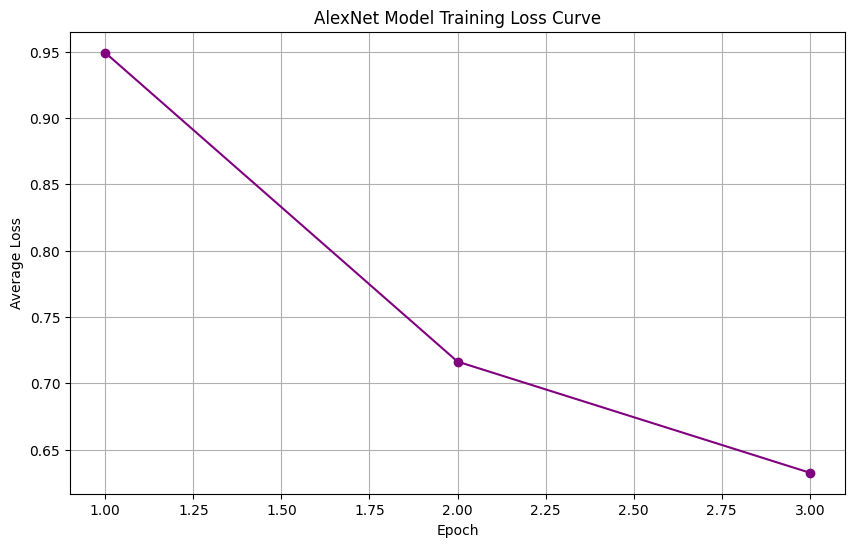

In [57]:
# Inputting data
epochs = [1, 2, 3]
average_loss = [0.949265, 0.716303, 0.632496]

# Set plot features
plt.figure(figsize=(10, 6))
plt.plot(epochs, average_loss, marker='o', linestyle='-', color='purple')

# Adding title and labels
plt.title('AlexNet Model Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)

# Display the plot
plt.show()